In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

import matplotlib.pyplot as plt

In [2]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [3]:
data_parh = "/papers_2000/"

In [4]:
short_papers = spark.read.json("../data/processed/"+data_parh+"/short_papers/")

In [5]:
short_papers.count()

7192

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

This is the list of assigned keywords from the whole dataset

In [7]:
kws  = short_papers.select(explode(col("keywords"))).select("col.value").withColumnRenamed("value", "K")
kws_counts = kws.groupby("K").count().sort(desc("count"))

In [8]:
short_papers.printSchema()

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- citation_count: long (nullable = true)
 |-- created: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- schema: string (nullable = true)
 |    |    |-- source: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- num_refs: long (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- title: string (nullable = true)



In [9]:
df_kws_counts = kws_counts.limit(1000).toPandas()["count"]

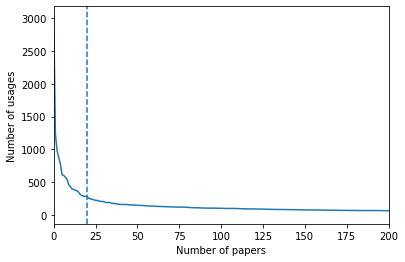

In [10]:
df_kws_counts.plot(style = "-")
plt.axvline(20, linestyle = "--")
#plt.axvline(100, linestyle = "--")
plt.xlim(0, 200)
plt.xlabel("Number of papers")
plt.ylabel("Number of usages")
plt.savefig("figures/assigned_kws_elbow.eps")

Select 20 or 100 most popular  words should be used. We will work with 20 for a while

In [11]:
tab_data = kws_counts.limit(20).collect()
tex = ""
for i, r in enumerate(tab_data):
#    print(i," ", r[0], r[1])
    tex = tex + "\t "+str(i+1) + " & " + r[0] + " & " + str(r[1]) + r" \\ " + "\n"
print(tex)

	 1 & numerical calculations & 3031 \\ 
	 2 & numerical calculations: interpretation of experiments & 1240 \\ 
	 3 & bibliography & 982 \\ 
	 4 & quantum chromodynamics & 876 \\ 
	 5 & supersymmetry & 778 \\ 
	 6 & CP: violation & 610 \\ 
	 7 & neutrino: oscillation & 602 \\ 
	 8 & Feynman graph & 573 \\ 
	 9 & electron positron: annihilation & 542 \\ 
	 10 & Feynman graph: higher-order & 459 \\ 
	 11 & effective Lagrangian & 429 \\ 
	 12 & neutrino: mixing angle & 395 \\ 
	 13 & neutrino: mass & 389 \\ 
	 14 & neutrino: solar & 373 \\ 
	 15 & perturbation theory: higher-order & 369 \\ 
	 16 & Higgs particle: mass & 341 \\ 
	 17 & electroweak interaction & 307 \\ 
	 18 & neutrino: cosmic radiation & 293 \\ 
	 19 & p p: inclusive reaction & 283 \\ 
	 20 & critical phenomena & 282 \\ 



In [12]:
# replacing some characters with _
import re
def format_kwd(kwd):
    return re.sub("[\.-/ :()]", "_", kwd)

In [13]:
selected_keywords = kws_counts.limit(20).toPandas()["K"].tolist()
selected_keywords = [format_kwd(K) for K in selected_keywords] + ["None"]
#selected_keywords

In [14]:
# from https://www.geeksforgeeks.org/python-intersection-two-lists/
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

from pyspark.sql.functions import monotonically_increasing_id

Extracting these keywords to a column

In [15]:
# returns first keyword
@udf(returnType=ArrayType(StringType()))
def list_keywords(a):
    return [format_kwd(aa["value"]) for aa in a] if a else ["None"]

@udf(returnType=ArrayType(StringType()))
def filtered_list_keywords(a):
    kws_list = [format_kwd(aa["value"]) for aa in a] if a else ["None"]
    kws_list = intersection(kws_list, selected_keywords)
    return kws_list if kws_list else ["None"]

withKeywords = short_papers.withColumn("keywords_", filtered_list_keywords(col("keywords"))) # .withColumn("id", monotonically_increasing_id())

In [16]:
# Creating dummy variables
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import monotonically_increasing_id
dummy_df = withKeywords
for kw in selected_keywords:
    dummy_df = dummy_df.withColumn(
        kw.replace(".", "_"), 
        array_contains(col("keywords_"), kw).cast("int")
    )
dummy_df = dummy_df.select( ["title","number_of_pages", "citation_count", "num_refs"] + selected_keywords)
dummy_df = dummy_df.withColumn("id", monotonically_increasing_id())
dummy_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- number_of_pages: long (nullable = true)
 |-- citation_count: long (nullable = true)
 |-- num_refs: long (nullable = true)
 |-- numerical_calculations: integer (nullable = true)
 |-- numerical_calculations__interpretation_of_experiments: integer (nullable = true)
 |-- bibliography: integer (nullable = true)
 |-- quantum_chromodynamics: integer (nullable = true)
 |-- supersymmetry: integer (nullable = true)
 |-- CP__violation: integer (nullable = true)
 |-- neutrino__oscillation: integer (nullable = true)
 |-- Feynman_graph: integer (nullable = true)
 |-- electron_positron__annihilation: integer (nullable = true)
 |-- Feynman_graph__higher-order: integer (nullable = true)
 |-- effective_Lagrangian: integer (nullable = true)
 |-- neutrino__mixing_angle: integer (nullable = true)
 |-- neutrino__mass: integer (nullable = true)
 |-- neutrino__solar: integer (nullable = true)
 |-- perturbation_theory__higher-order: integer (nullable = true)
 |-- 

In [17]:
dummy_df.write.mode("overwrite").json("../data/processed/"+data_parh+"/kws/dummy/")

In [48]:
import numpy as np

In [36]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=dummy_df.columns[1:10], outputCol=vector_col)
vector_df = assembler.transform(dummy_df).select(vector_col)

In [37]:
vector_df.limit(10).collect()

[Row(corr_features=SparseVector(9, {0: 7.0, 2: -1.0, 7: 1.0, 8: 1.0})),
 Row(corr_features=SparseVector(9, {0: 11.0, 2: -1.0, 8: 1.0})),
 Row(corr_features=DenseVector([12.0, 4.0, -1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0])),
 Row(corr_features=SparseVector(9, {0: 2.0, 1: 15.0, 2: 6.0})),
 Row(corr_features=SparseVector(9, {0: 12.0, 1: 1.0, 2: -1.0, 7: 1.0})),
 Row(corr_features=SparseVector(9, {0: 322.0, 2: -1.0})),
 Row(corr_features=SparseVector(9, {0: 5.0, 1: 4.0, 2: 40.0})),
 Row(corr_features=DenseVector([6.0, 1.0, 35.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0])),
 Row(corr_features=SparseVector(9, {0: 6.0, 1: 1.0, 2: 8.0, 3: 1.0})),
 Row(corr_features=SparseVector(9, {0: 6.0, 1: 18.0, 2: 9.0}))]

In [41]:
from pyspark.ml.stat import Correlation

In [42]:
?Correlation

Init signature: Correlation()
Docstring:     
Compute the correlation matrix for the input dataset of Vectors using the specified method.
Methods currently supported: `pearson` (default), `spearman`.

.. versionadded:: 2.2.0

Notes
-----
For Spearman, a rank correlation, we need to create an RDD[Double] for each column
and sort it in order to retrieve the ranks and then join the columns back into an RDD[Vector],
which is fairly costly. Cache the input Dataset before calling corr with `method = 'spearman'`
to avoid recomputing the common lineage.
File:           /usr/local/spark/python/pyspark/ml/stat.py
Type:           type
Subclasses:     


In [65]:
cols = dummy_df.columns[1:]
dummy_df.stat.corr(cols[10], cols[24])

-0.025303399965849505

In [48]:
Correlation.corr(vector_df, vectot_col)

Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 51.0 failed 1 times, most recent failure: Lost task 3.0 in stage 51.0 (TID 136) (7aaf0255f268 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4188/0x0000000841533040: (struct<number_of_pages_double_VectorAssembler_79ffbb51380f:double,citation_count_double_VectorAssembler_79ffbb51380f:double,num_refs_double_VectorAssembler_79ffbb51380f:double,numerical_calculations_double_VectorAssembler_79ffbb51380f:double,numerical_calculations__interpretation_of_experiments_double_VectorAssembler_79ffbb51380f:double,bibliography_double_VectorAssembler_79ffbb51380f:double,quantum_chromodynamics_double_VectorAssembler_79ffbb51380f:double,supersymmetry_double_VectorAssembler_79ffbb51380f:double,CP__violation_double_VectorAssembler_79ffbb51380f:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 36 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2309)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:441)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corrMatrix(Correlation.scala:66)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:90)
	at org.apache.spark.ml.stat.Correlation$.corr(Correlation.scala:71)
	at org.apache.spark.ml.stat.Correlation.corr(Correlation.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4188/0x0000000841533040: (struct<number_of_pages_double_VectorAssembler_79ffbb51380f:double,citation_count_double_VectorAssembler_79ffbb51380f:double,num_refs_double_VectorAssembler_79ffbb51380f:double,numerical_calculations_double_VectorAssembler_79ffbb51380f:double,numerical_calculations__interpretation_of_experiments_double_VectorAssembler_79ffbb51380f:double,bibliography_double_VectorAssembler_79ffbb51380f:double,quantum_chromodynamics_double_VectorAssembler_79ffbb51380f:double,supersymmetry_double_VectorAssembler_79ffbb51380f:double,CP__violation_double_VectorAssembler_79ffbb51380f:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 36 more
